In [1]:
from sage.matrix.berlekamp_massey import berlekamp_massey
from sage.matrix.special import *
import random
import matplotlib.pyplot as plt
import numpy as np
def rand_list(n, card):
    return [random.randint(0, card) for _ in range(n)]

In [2]:
def mat_gen(q, n):
    D = diagonal_matrix(GF(q), rand_list(n, q))
    T = toeplitz(rand_list(n, q), rand_list(n - 1, q), GF(q))
    J = jordan_block(random.randint(2, q), n)
    S = random_matrix(GF(q), n, n, sparse=True, density=0.05)
    return [D, T, J, S]

In [3]:
def random_vector(n, f):
    return vector(f, [f.random_element() for _ in range(n)])
def krylov(A, q):
    f = GF(q)
    n = A.nrows()
    u = random_vector(n, f)
    v = random_vector(n, f)
    return [u*(A^i*v) for i in range(2*n)]

In [4]:
def early_BM(q, sequence, n, c=3):
    ω = c*log(n, q)
    f = GF(q)
    R = PolynomialRing(f, "x")
    sequence = [f(s) for s in sequence]
    C = [f(1)]
    B = [f(1)]
    L = 0
    m = 1
    streak = 1
    b = f(1)
    stop = 0
    for k in range(len(sequence)):
        d = sequence[k] + sum(C[i] * sequence[k - i] for i in range(1, L + 1))
        if d == 0:
            m += 1
            streak += 1
            if streak >= ω:
                stop = k
                break
        elif 2 * L <= k:
            T = C[:]
            C += [f(0)] * (m + len(B) - len(C))
            for i in range(len(B)):
                C[i + m] -= d / b * B[i]
            L = k + 1 - L
            B = T
            b = d
            m = 1
            streak = 1
        else:
            C += [f(0)] * (m + len(B) - len(C))
            for i in range(len(B)):
                C[i + m] -= d / b * B[i]
            m += 1
            streak = 1
    else: 
        stop = 2*n
    # result processing before return
    C = C[::-1]
    while len(C) > 1 and C[0] == 0:
        C = C[1:]
    return R(C), stop

In [5]:
n_list = [10, 30, 50]
q = 5
trials = 20
gen_trials = 10

mat_ref = ['Diagonal', 'Toeplitz', 'Jordan', 'Sparse']
cumu_stop_at = {}
cumu_success = {}

for n in n_list:
    print(n)
    stop_at = {}
    success = {}

    # Initialize accumulators for each matrix type
    for name in mat_ref:
        stop_at[name] = 0.0
        success[name] = 0.0

    for _ in range(gen_trials):  # Matrix generation loop
        matlist = mat_gen(q, n)
        for i in range(len(matlist)):
            mat = matlist[i]
            avg_stop_at = 0.0
            avg_success = 0.0

            for _ in range(trials):  # Trial loop
                k = krylov(mat, q)
                b_early, stop = early_BM(q, k, n)
                avg_stop_at += stop
                if b_early == berlekamp_massey(k):
                    avg_success += 1

            # Average over trials
            avg_stop_at /= trials
            avg_success /= trials

            matname = mat_ref[i]
            stop_at[matname] += avg_stop_at
            success[matname] += avg_success

    # Final average over matrix generations
    for name in mat_ref:
        stop_at[name] /= gen_trials
        success[name] /= gen_trials

    # Store per-n results
    cumu_stop_at[n] = stop_at
    cumu_success[n] = success

print(cumu_success)
print()
print(cumu_stop_at)


10
30
50
{10: {'Diagonal': 1.00000000000000, 'Toeplitz': 0.985000000000000, 'Jordan': 0.985000000000000, 'Sparse': 1.00000000000000}, 30: {'Diagonal': 1.00000000000000, 'Toeplitz': 1.00000000000000, 'Jordan': 0.990000000000000, 'Sparse': 1.00000000000000}, 50: {'Diagonal': 1.00000000000000, 'Toeplitz': 0.995000000000000, 'Jordan': 1.00000000000000, 'Sparse': 1.00000000000000}}

{10: {'Diagonal': 9.09000000000000, 'Toeplitz': 19.6150000000000, 'Jordan': 19.6000000000000, 'Sparse': 8.73500000000000}, 30: {'Diagonal': 12.6000000000000, 'Toeplitz': 59.9800000000000, 'Jordan': 59.5400000000000, 'Sparse': 31.9650000000000}, 50: {'Diagonal': 13.7000000000000, 'Toeplitz': 99.5200000000000, 'Jordan': 99.9250000000000, 'Sparse': 79.1550000000000}}


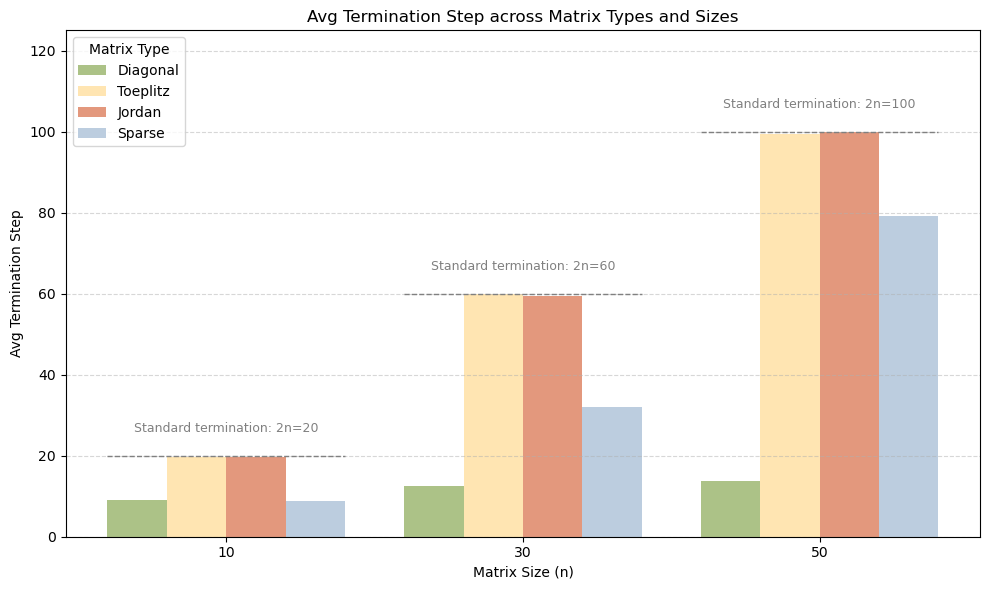

In [6]:
data = cumu_stop_at

matrix_types = ['Diagonal', 'Toeplitz', 'Jordan', 'Sparse']
n_values = list(data.keys())
x = np.arange(len(n_values))

bar_width = 0.2
colors = {
    'Diagonal': '#ACC287',
    'Toeplitz': '#FFE5B2',
    'Jordan': '#E3987D',
    'Sparse': '#BCCDDF'
}

plt.figure(figsize=(10, 6))

for i, mat_type in enumerate(matrix_types):
    values = [data[n][mat_type] for n in n_values]
    plt.bar(x + i * bar_width, values, width=bar_width, label=mat_type, color=colors[mat_type])

margin = 0.1  # length to extend benchmark line on each side

for i, n in enumerate(n_values):
    group_start = x[i] - margin
    group_end = x[i] + (len(matrix_types) - 1) * bar_width + margin
    y = 2 * n
    plt.hlines(y=y, xmin=group_start, xmax=group_end, color='gray', linestyle='--', linewidth=1)
    plt.text((group_start + group_end) / 2, y + 5, f'Standard termination: 2n={y}', ha='center', va='bottom', fontsize=9, color='gray')

plt.xlabel('Matrix Size (n)')
plt.ylabel('Avg Termination Step')
plt.title('Avg Termination Step across Matrix Types and Sizes (over GF(5))')
plt.xticks(x + (len(matrix_types) - 1) * bar_width / 2, n_values)
plt.legend(title="Matrix Type")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.ylim(0, 125)
plt.show()


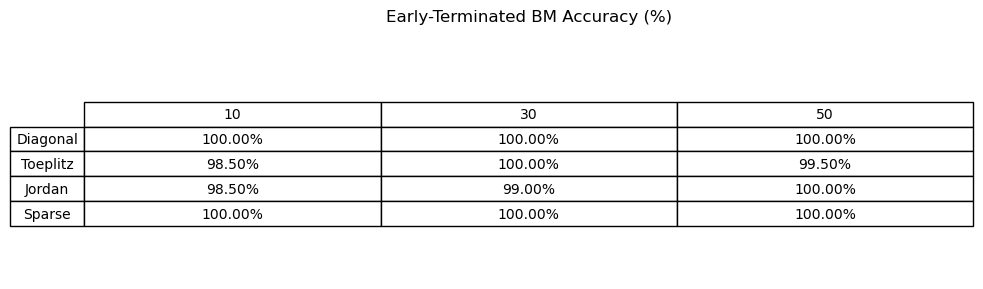

In [7]:

# Assume cumu_success = {n: {mat_type: accuracy_value, ...}, ...}
data = cumu_success
matrix_types = ['Diagonal', 'Toeplitz', 'Jordan', 'Sparse']
n_values = list(data.keys())

# Build a 2D list of accuracy values
cell_data = []
for mat_type in matrix_types:
    row = [f"{data[n][mat_type]*100:.2f}%" for n in n_values]
    cell_data.append(row)

# Plot table
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')  # Hide axes

table = ax.table(
    cellText=cell_data,
    rowLabels=matrix_types,
    colLabels=n_values,
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # (col_width, row_height)

plt.title("Early-Terminated BM Accuracy (%)", pad=20)
plt.tight_layout()
plt.show()

In [8]:
ref = [
    "Diagonal (repeated eigs)",
    "Diagonal (distinct eigs)",
    "Jordan-10 (repeated eigs)",
    "Jordan-10 (distinct eigs)",
    "Jordan-5 (repeated eigs)",
    "Jordan-5 (distinct eigs)"
]

def jordan_mat_gen(q, n):
    F = GF(q)
    eigenvals = list(F)

    # Diagonal, repeated λ's
    lam = F.random_element()
    Dr = diagonal_matrix(F, [lam] * n)

    # Diagonal, distinct (cycled if needed) λ's
    Dd = diagonal_matrix(F, [eigenvals[i % q] for i in range(n)])

    # 10 Jordan blocks, repeated λ's (1x1 blocks)
    lam = F.random_element()
    J10r = block_diagonal_matrix([jordan_block(lam, 1) for _ in range(n)])

    # 10 Jordan blocks, distinct (cycled) λ's (1x1 blocks)
    J10d = block_diagonal_matrix([jordan_block(eigenvals[i % q], 1) for i in range(n)])

    # 5 Jordan blocks, repeated λ's (larger blocks)
    if n % 5 != 0:
        raise ValueError("n must be divisible by 5 for 5 equal-sized Jordan blocks.")
    block_size = n // 5
    lam = F.random_element()
    J5r = block_diagonal_matrix([jordan_block(lam, block_size) for _ in range(5)])

    # 5 Jordan blocks, distinct (cycled) λ's
    J5d = block_diagonal_matrix([jordan_block(eigenvals[i % q], block_size) for i in range(5)])

    return [Dr, Dd, J10r, J10d, J5r, J5d]

In [9]:
n_list = [10*i for i in range(2, 9)]
q = 97
trials = 200
gen_trials = 1

mat_ref = [
    "Diagonal (repeated eigs)",
    "Diagonal (distinct eigs)",
    "10 Jordan blocks (repeated eigs)",
    "10 Jordan blocks (distinct eigs)",
    "5 Jordan blocks (repeated eigs)",
    "5 Jordan blocks (distinct eigs)"
]
cumu_stop_at = {}
cumu_success = {}

for n in n_list:
    print(n)
    stop_at = {}
    success = {}

    # Initialize accumulators for each matrix type
    for name in mat_ref:
        stop_at[name] = 0.0
        success[name] = 0.0

    for _ in range(gen_trials):  # Matrix generation loop
        matlist = jordan_mat_gen(q, n)
        for i in range(len(matlist)):
            mat = matlist[i]
            avg_stop_at = 0.0
            avg_success = 0.0

            for _ in range(trials):  # Trial loop
                k = krylov(mat, q)
                b_early, stop = early_BM(q, k, n)
                avg_stop_at += stop
                if b_early == berlekamp_massey(k):
                    avg_success += 1

            # Average over trials
            avg_stop_at /= trials
            avg_success /= trials

            matname = mat_ref[i]
            stop_at[matname] += avg_stop_at
            success[matname] += avg_success

    # Final average over matrix generations
    for name in mat_ref:
        stop_at[name] /= gen_trials
        success[name] /= gen_trials

    # Store per-n results
    cumu_stop_at[n] = stop_at
    cumu_success[n] = success

print(cumu_success)
print()
print(cumu_stop_at)

20
30
40
50
60
70
80
{20: {'Diagonal (repeated eigs)': 1.00000000000000, 'Diagonal (distinct eigs)': 0.655000000000000, '10 Jordan blocks (repeated eigs)': 1.00000000000000, '10 Jordan blocks (distinct eigs)': 0.680000000000000, '5 Jordan blocks (repeated eigs)': 0.970000000000000, '5 Jordan blocks (distinct eigs)': 0.680000000000000}, 30: {'Diagonal (repeated eigs)': 1.00000000000000, 'Diagonal (distinct eigs)': 0.990000000000000, '10 Jordan blocks (repeated eigs)': 1.00000000000000, '10 Jordan blocks (distinct eigs)': 0.995000000000000, '5 Jordan blocks (repeated eigs)': 1.00000000000000, '5 Jordan blocks (distinct eigs)': 0.995000000000000}, 40: {'Diagonal (repeated eigs)': 1.00000000000000, 'Diagonal (distinct eigs)': 0.995000000000000, '10 Jordan blocks (repeated eigs)': 1.00000000000000, '10 Jordan blocks (distinct eigs)': 0.995000000000000, '5 Jordan blocks (repeated eigs)': 1.00000000000000, '5 Jordan blocks (distinct eigs)': 0.990000000000000}, 50: {'Diagonal (repeated eigs)':

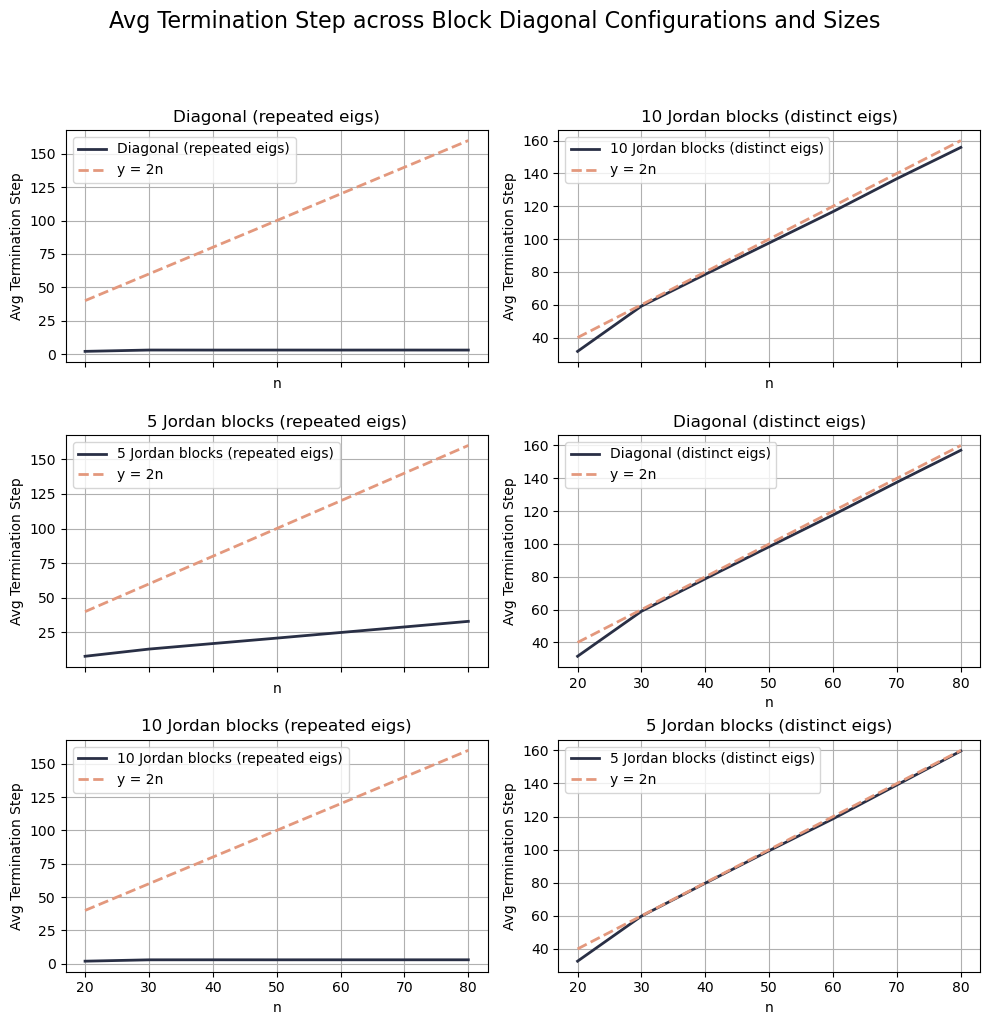

In [16]:

# Custom plot order
order = [
    "Diagonal (repeated eigs)",
    "10 Jordan blocks (distinct eigs)",
    "5 Jordan blocks (repeated eigs)",
    "Diagonal (distinct eigs)",
    "10 Jordan blocks (repeated eigs)",
    "5 Jordan blocks (distinct eigs)"
]

# Data
data = cumu_stop_at  # <- make sure this is defined before

# Matrix sizes
n_values = sorted(data.keys())

# Subplot configuration
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()

# Plot each matrix type in the specified order
for i, matrix_type in enumerate(order):
    y_values = [data[n][matrix_type] for n in n_values]
    axs[i].plot(n_values, y_values, color='#292F45', label=matrix_type, linewidth=2)
    axs[i].plot(n_values, [2 * n for n in n_values], '--', color='#E3987D', label='y = 2n', linewidth=2)
    axs[i].set_title(matrix_type)
    axs[i].set_ylabel('Avg Termination Step')
    axs[i].grid(True)
    axs[i].legend()

# Set shared x-label
for ax in axs:
    ax.set_xlabel('n')

# Hide x-tick labels for top row for cleaner look
for ax in axs[:3]:
    ax.set_xticklabels([])

# Final layout adjustments
plt.tight_layout()
plt.suptitle('Avg Termination Step across Block Diagonal Configurations and Sizes', fontsize=16, y=1.02)
plt.subplots_adjust(top=0.90)
plt.show()


In [11]:
# n = 50
# q = 31
# trials = 100
# gen_trials = 10

# mat_ref = ['Diagonal', 'Toeplitz', 'Jordan', 'Sparse']
# cumu_standard = {}
# cumu_early = {}

# # Initialize accumulators for each matrix type
# standard_total = {name: 0.0 for name in mat_ref}
# early_total = {name: 0.0 for name in mat_ref}

# for j in range(gen_trials):  # Matrix generation loop
#     print(j)
#     matlist = mat_gen(q, n)  # returns a list of 4 matrices
#     for i, mat in enumerate(matlist):
#         matname = mat_ref[i]
#         minpoly = mat.minpoly()
#         standard_success = 0
#         early_success = 0

#         for _ in range(trials):  # Trial loop
#             k = krylov(mat, q)
#             b_early, _ = early_BM(q, k, n)
#             if b_early == minpoly:
#                 early_success += 1
#             if berlekamp_massey(k) == minpoly:
#                 standard_success += 1

#         # Average over this trial set
#         standard_total[matname] += standard_success / trials
#         early_total[matname] += early_success / trials

# # Final average over all matrix generations
# for name in mat_ref:
#     standard_total[name] /= gen_trials
#     early_total[name] /= gen_trials

# # # Store per-n results
# # cumu_standard[n] = standard_total
# # cumu_early[n] = early_total

# # Print results
# print("Standard BM Accuracy:")
# print(standard_total)

# print("\nEarly-Terminated BM Accuracy:")
# print(early_total)


In [12]:
n = 50
q = 31
trials = 100
gen_trials = 1

def w_mat_gen(q, n):
    F = GF(q)
    eigenvals = list(F)
    random.shuffle(eigenvals)

    T = toeplitz(rand_list(n, q), rand_list(n - 1, q), GF(q))
    J = jordan_block(random.randint(2, q), n)

    lam = F.random_element()
    Dr = diagonal_matrix(F, [lam] * n)

    Dd = diagonal_matrix(F, [eigenvals[i % len(eigenvals)] for i in range(n)])

    lam = F.random_element()
    J10r = block_diagonal_matrix([jordan_block(lam, 1) for _ in range(n)])

    J10d = block_diagonal_matrix([jordan_block(eigenvals[i % len(eigenvals)], 1) for i in range(n)])

    if n % 5 != 0:
        raise ValueError("n must be divisible by 5 for 5 equal-sized Jordan blocks.")
    block_size = n // 5
    lam = F.random_element()
    J5r = block_diagonal_matrix([jordan_block(lam, block_size) for _ in range(5)])
    J5d = block_diagonal_matrix([jordan_block(eigenvals[i % len(eigenvals)], block_size) for i in range(5)])

    return [Dr, Dd, J10r, J10d, J5r, J5d, T, J]

mat_ref = [
    "Diagonal (repeated eigs)",
    "Diagonal (distinct eigs)",
    "10 Jordan blocks (repeated eigs)",
    "10 Jordan blocks (distinct eigs)",
    "5 Jordan blocks (repeated eigs)",
    "5 Jordan blocks (distinct eigs)", 
    "Toeplitz", 
    "1 Jordan block"
]

cumu_standard = {}
cumu_early = {}

standard_total = {name: 0.0 for name in mat_ref}
early_total = {name: 0.0 for name in mat_ref}

for _ in range(gen_trials):
    matlist = w_mat_gen(q, n)
    for i, mat in enumerate(matlist):
        matname = mat_ref[i]
        minpoly = mat.minpoly()
        standard_success = 0
        early_success = 0

        for _ in range(trials):
            k = krylov(mat, q)
            b_early, _ = early_BM(q, k, n)
            if b_early == minpoly:
                early_success += 1
            if berlekamp_massey(k) == minpoly:
                standard_success += 1

        standard_total[matname] += standard_success / trials
        early_total[matname] += early_success / trials

# Average over matrix generations
for name in mat_ref:
    standard_total[name] /= gen_trials
    early_total[name] /= gen_trials

# Store per-n results
cumu_standard[n] = standard_total.copy()
cumu_early[n] = early_total.copy()

# Print results
print("Standard BM Accuracy:")
print(standard_total)

print("\nEarly-Terminated BM Accuracy:")
print(early_total)


Standard BM Accuracy:
{'Diagonal (repeated eigs)': 0.950000000000000, 'Diagonal (distinct eigs)': 0.000000000000000, '10 Jordan blocks (repeated eigs)': 0.960000000000000, '10 Jordan blocks (distinct eigs)': 0.000000000000000, '5 Jordan blocks (repeated eigs)': 0.960000000000000, '5 Jordan blocks (distinct eigs)': 0.670000000000000, 'Toeplitz': 0.980000000000000, '1 Jordan block': 0.950000000000000}

Early-Terminated BM Accuracy:
{'Diagonal (repeated eigs)': 0.950000000000000, 'Diagonal (distinct eigs)': 0.000000000000000, '10 Jordan blocks (repeated eigs)': 0.960000000000000, '10 Jordan blocks (distinct eigs)': 0.000000000000000, '5 Jordan blocks (repeated eigs)': 0.960000000000000, '5 Jordan blocks (distinct eigs)': 0.670000000000000, 'Toeplitz': 0.980000000000000, '1 Jordan block': 0.950000000000000}


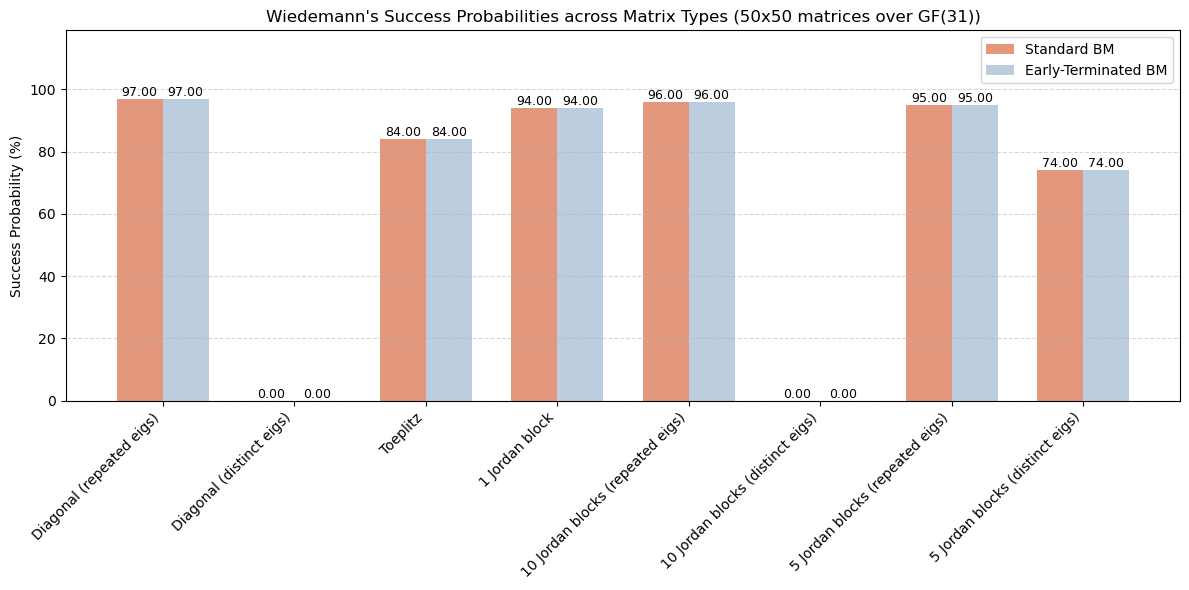

In [13]:
# Accuracy data
standard = {
    'Diagonal (repeated eigs)': 0.97,
    'Diagonal (distinct eigs)': 0.00,
    'Toeplitz': 0.84,
    '1 Jordan block': 0.94,
    '10 Jordan blocks (repeated eigs)': 0.96,
    '10 Jordan blocks (distinct eigs)': 0.00,
    '5 Jordan blocks (repeated eigs)': 0.95,
    '5 Jordan blocks (distinct eigs)': 0.74
}

early = {
    'Diagonal (repeated eigs)': 0.97,
    'Diagonal (distinct eigs)': 0.00,
    'Toeplitz': 0.84,
    '1 Jordan block': 0.94,
    '10 Jordan blocks (repeated eigs)': 0.96,
    '10 Jordan blocks (distinct eigs)': 0.00,
    '5 Jordan blocks (repeated eigs)': 0.95,
    '5 Jordan blocks (distinct eigs)': 0.74,
}

# Matrix types (ordered)
labels = list(standard.keys())

# Values
standard_vals = [standard[k]*100 for k in labels]
early_vals = [early[k]*100 for k in labels]

# Plot settings
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, standard_vals, width, label='Standard BM', color='#E3987D')
bars2 = ax.bar(x + width/2, early_vals, width, label='Early-Terminated BM', color='#BCCDDF')

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_ylabel('Success Probability (%)')
ax.set_title("Wiedemann's Success Probabilities across Matrix Types (50x50 matrices over GF(31))")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0, 119)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [14]:
mat = jordan_block(2, 30)
minpoly = mat.minpoly()
primes_list = prime_range(1, 1000)
trials = 50

standard = {}
early = {}

for q in primes_list:
    success_std = 0
    success_early = 0
    
    for _ in range(trials):
        try:
            k = krylov(mat, q)
            b_early, _ = early_BM(q, k, mat.nrows())
            b_std = berlekamp_massey(k)

            if b_std == minpoly:
                success_std += 1
            if b_early == minpoly:
                success_early += 1
        except Exception as e:
            # In case some field operation fails (e.g., q too small, etc.)
            print(f"Error at q={q}: {e}")
            continue

    standard[q] = success_std / trials
    early[q] = success_early / trials

# Optional: Print or plot
print("Standard BM Success Rates:")
print(standard)

print("\nEarly-Terminated BM Success Rates:")
print(early)

Standard BM Success Rates:
{2: 0, 3: 13/25, 5: 33/50, 7: 19/25, 11: 37/50, 13: 9/10, 17: 22/25, 19: 9/10, 23: 49/50, 29: 22/25, 31: 47/50, 37: 9/10, 41: 1, 43: 22/25, 47: 49/50, 53: 24/25, 59: 1, 61: 49/50, 67: 24/25, 71: 1, 73: 49/50, 79: 49/50, 83: 1, 89: 1, 97: 49/50, 101: 1, 103: 49/50, 107: 1, 109: 49/50, 113: 1, 127: 1, 131: 1, 137: 1, 139: 24/25, 149: 1, 151: 49/50, 157: 1, 163: 1, 167: 1, 173: 1, 179: 1, 181: 24/25, 191: 47/50, 193: 1, 197: 1, 199: 1, 211: 1, 223: 49/50, 227: 49/50, 229: 1, 233: 47/50, 239: 49/50, 241: 1, 251: 24/25, 257: 1, 263: 49/50, 269: 1, 271: 49/50, 277: 1, 281: 1, 283: 1, 293: 1, 307: 1, 311: 1, 313: 1, 317: 1, 331: 1, 337: 1, 347: 1, 349: 1, 353: 1, 359: 1, 367: 49/50, 373: 49/50, 379: 1, 383: 1, 389: 1, 397: 1, 401: 1, 409: 1, 419: 24/25, 421: 1, 431: 49/50, 433: 1, 439: 1, 443: 49/50, 449: 49/50, 457: 1, 461: 1, 463: 1, 467: 1, 479: 1, 487: 1, 491: 1, 499: 1, 503: 49/50, 509: 1, 521: 1, 523: 1, 541: 1, 547: 1, 557: 1, 563: 49/50, 569: 24/25, 571: 49/

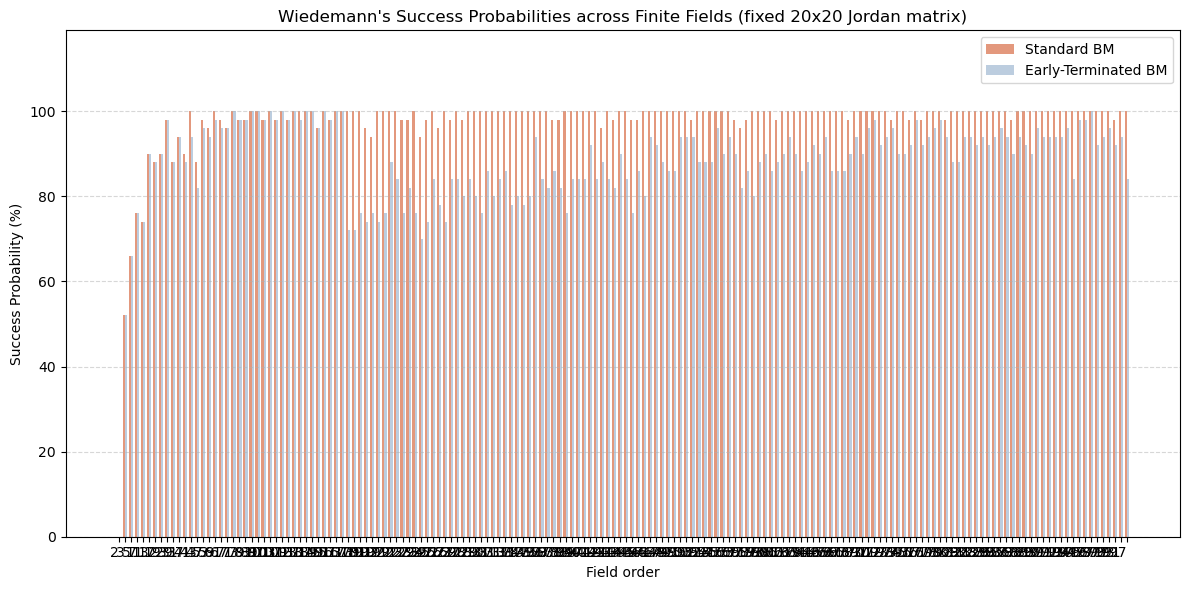

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Matrix types (ordered)
labels = list(standard.keys())

# Values
standard_vals = [float(standard[k]*100) for k in labels]
early_vals = [float(early[k]*100) for k in labels]

# Plot settings
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, standard_vals, width, label='Standard BM', color='#E3987D')
bars2 = ax.bar(x + width/2, early_vals, width, label='Early-Terminated BM', color='#BCCDDF')

# # Add value labels on top of bars
# for bar in bars1:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# for bar in bars2:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_ylabel('Success Probability (%)')
ax.set_xlabel('Field order')
ax.set_title("Wiedemann's Success Probabilities across Finite Fields (fixed 20x20 Jordan matrix)")
ax.set_xticks(x)
ax.set_xticklabels(labels, ha='right')
ax.set_ylim(0, 119)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
